In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#Read hypergeometric results from Deleteome (unfiltered by statistics)
results_up_df = pd.read_csv("Deleteome_unfiltered_up_DEGs_hypergeometric_results.csv", index_col=0)
results_up_df.head()

,Condition,Knockout Profile,Overlap Count,P-value,Representation Factor,Adjusted P-value BY
0,rpd3KO,ptc1-del vs. wt,36,1.098874e-11,3.517996,4.367207e-10
1,rpd3KO,tlc1-del vs. wt,44,3.088899e-07,2.215924,6.985113e-06
2,rpd3KO,swa2-del vs. wt,40,1.201051e-09,2.810674,3.729565e-08
3,rpd3KO,asf1-del vs. wt,8,1.607547e-02,2.409149,1.512544e-01
4,rpd3KO,vps16-del vs. wt,14,1.029318e-04,3.130069,1.633871e-03


In [3]:
results_up_df[results_up_df['Knockout Profile'] == 'ash1-del vs. wt']  #NA due to zero overlaps & R.F wasn't computed 

,Condition,Knockout Profile,Overlap Count,P-value,Representation Factor,Adjusted P-value BY


In [4]:
results_up_df[results_up_df['Knockout Profile'] == 'rxt3-del vs. wt'] #E6R is highly enriched for rxt3KO profile 

,Condition,Knockout Profile,Overlap Count,P-value,Representation Factor,Adjusted P-value BY
166,rpd3KO,rxt3-del vs. wt,3,0.001174,11.067029,0.015067
401,Sin3KO,rxt3-del vs. wt,2,0.027323,7.054273,0.235830
1000,TSA,rxt3-del vs. wt,2,0.015482,9.486025,0.146707
1286,E6R,rxt3-del vs. wt,3,0.000409,15.799138,0.005669


In [5]:
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib as mpl

#Define relevant HDAC KO profiles

#Define targets => only interested in showing 11 HDAC subunits here. 
red_conditions = ['rpd3-del vs. wt', 'sin3-del vs. wt', 'sds3-del vs. wt', 'dep1-del vs. wt', 
                  'sap30-del vs. wt', 'rxt2-del vs. wt', 'pho23-del vs. wt', 'ume1-del vs. wt', 
                  'ash1-del vs. wt', 'cti6-del vs. wt', 'rxt3-del vs. wt']

#Helper to extract from up/down full results
def extract_repr_and_sig(df, label):
    df = df[df['Knockout Profile'].isin(red_conditions)]
    df = df[['Condition', 'Knockout Profile', 'Representation Factor', 'Adjusted P-value BY']].copy()
    df = df.rename(columns={
        'Representation Factor': f'Representation Factor_{label}',
        'Adjusted P-value BY': f'Adjusted P-value_{label}'
    })
    return df

up_repr_df = extract_repr_and_sig(results_up_df, 'up')
up_repr_df.head()

,Condition,Knockout Profile,Representation Factor_up,Adjusted P-value_up
13,rpd3KO,sds3-del vs. wt,12.712895,1.375882e-54
51,rpd3KO,cti6-del vs. wt,9.837359,1.278947e-01
57,rpd3KO,rxt2-del vs. wt,12.911534,2.937572e-20
102,rpd3KO,sap30-del vs. wt,13.979405,4.355297e-38
117,rpd3KO,dep1-del vs. wt,12.586033,5.360983e-56


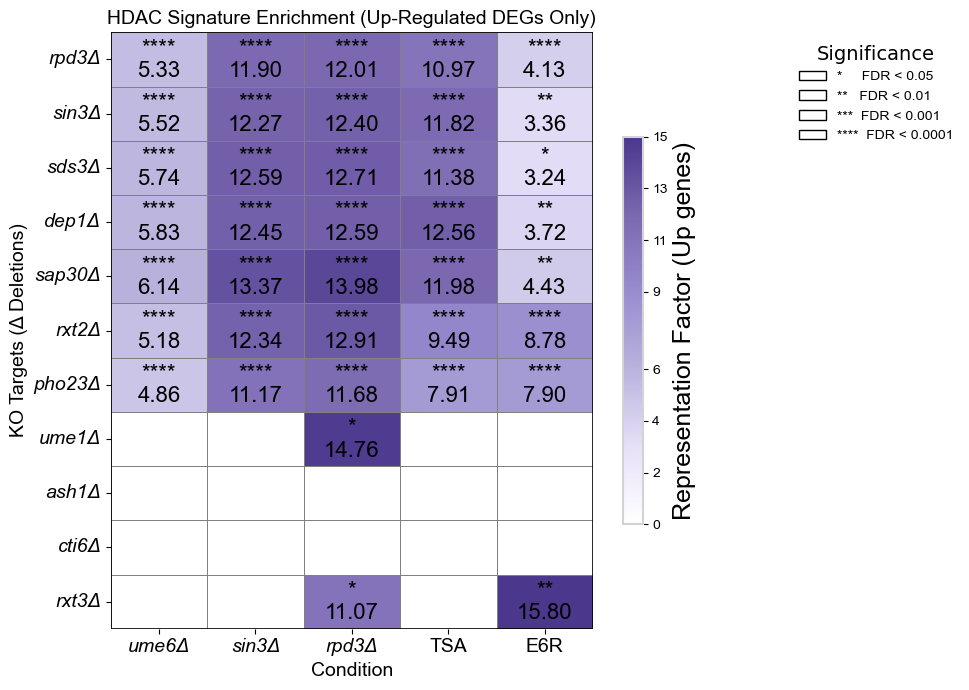

In [6]:
#KO label renaming
ylabels = {
    'rpd3-del vs. wt': 'rpd3Δ', 'sin3-del vs. wt': 'sin3Δ', 'sds3-del vs. wt': 'sds3Δ',
    'dep1-del vs. wt': 'dep1Δ', 'sap30-del vs. wt': 'sap30Δ', 'rxt2-del vs. wt': 'rxt2Δ',
    'pho23-del vs. wt': 'pho23Δ', 'ume1-del vs. wt': 'ume1Δ', 'ash1-del vs. wt': 'ash1Δ',
    'cti6-del vs. wt': 'cti6Δ', 'rxt3-del vs. wt': 'rxt3Δ'
}

final_conditions = ['rpd3KO', 'Sin3KO', 'TSA', 'E6R', 'Ume6KO']
ordered_y = [ylabels[k] for k in ylabels]

#Pivot heatmap & FDR matrix
heatmap_data = up_repr_df.pivot(index='Knockout Profile', columns='Condition', values='Representation Factor_up')
heatmap_data.index = [ylabels.get(x, x) for x in heatmap_data.index]
heatmap_data = heatmap_data.reindex(index=ordered_y, columns=final_conditions)

pval_df = up_repr_df.pivot(index='Knockout Profile', columns='Condition', values='Adjusted P-value_up')
pval_df.index = [ylabels.get(x, x) for x in pval_df.index]
pval_df = pval_df.reindex(index=ordered_y, columns=final_conditions)

color_data = heatmap_data.copy()
color_data[pval_df >= 0.05] = np.nan

# ======== AMEND: Encode Four stars for FDR < 0.0001 to be consistent with other figures ========
annot_matrix = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns)
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        val = heatmap_data.loc[row, col]
        pval = pval_df.loc[row, col]
        if pd.notnull(val) and pd.notnull(pval) and pval < 0.05:
            if pval < 0.0001:
                stars = '****'
            elif pval < 0.001:
                stars = '***'
            elif pval < 0.01:
                stars = '**'
            else:
                stars = '*'
            annot_matrix.loc[row, col] = f"{stars}\n{val:.2f}"
        else:
            annot_matrix.loc[row, col] = ""

#Rename columns
column_rename = {
    'Ume6KO': 'ume6Δ',
    'Sin3KO': 'sin3Δ',
    'rpd3KO': 'rpd3Δ',
    'TSA': 'TSA',
    'E6R': 'E6R'
}
color_data = color_data.rename(columns=column_rename)
annot_matrix = annot_matrix.rename(columns=column_rename)
column_order = ['ume6Δ', 'sin3Δ', 'rpd3Δ', 'TSA', 'E6R']
color_data = color_data[column_order]
annot_matrix = annot_matrix[column_order]

#Purple color gradient
refined_purple = mpl.colors.LinearSegmentedColormap.from_list(
    "RefinedGreenGradient", 
    [
        "#FFFFFF",    #0
        "#E6E0F8",    #~1 (very light lavender)
        "#B9B3DD",    #2–3 (light violet)
        "#998CCF",    #4–6 (soft mid-purple)
        "#7B68B0",    #6–11 (deep violet)
        "#4B378C"     #11–15 (dark purple)
    ]
)

#Mask NA cells
mask = color_data.isna()

#Plot
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    color_data,
    annot=annot_matrix,
    fmt='',
    cmap=refined_purple,
    mask=mask,
    linewidths=0.5,
    linecolor='grey',
    vmin=0, vmax=15,
    cbar_kws={
        'label': 'Representation Factor (Up genes)',
        'ticks': [0, 2, 4, 6, 9, 11, 13, 15],
        'shrink': 0.65
    },
    annot_kws={
        "fontsize": 16,
        "color": "black",
        "fontproperties": mpl.font_manager.FontProperties(
            fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf")
    },
    ax=ax
)

#Colorbar styling
cbar = ax.collections[0].colorbar
cbar.outline.set_edgecolor('lightgrey')
cbar.outline.set_linewidth(1.5)
cbar.ax.tick_params(labelsize=16)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(mpl.font_manager.FontProperties(
        fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf"))
cbar.set_label("Representation Factor (Up genes)", 
               fontsize=18, 
               fontproperties=mpl.font_manager.FontProperties(fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf"))

#Add border around heatmap
ax.add_patch(plt.Rectangle(
    (0, 0),
    color_data.shape[1],
    color_data.shape[0],
    fill=False,
    edgecolor='black',
    linewidth=1.2,
    zorder=10
))

#Axis fonts
for label in ax.get_yticklabels():
    label.set_fontproperties(mpl.font_manager.FontProperties(
        fname="/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf"))
    label.set_fontsize(14)

for label in ax.get_xticklabels():
    if label.get_text() in ['ume6Δ', 'sin3Δ', 'rpd3Δ']:
        label.set_fontproperties(mpl.font_manager.FontProperties(
            fname="/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf"))
    else:
        label.set_fontproperties(mpl.font_manager.FontProperties(
            fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf"))
    label.set_fontsize(14)

#Legend for stars
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='*     FDR < 0.05'),
    Patch(facecolor='white', edgecolor='black', label='**   FDR < 0.01'),
    Patch(facecolor='white', edgecolor='black', label='***  FDR < 0.001'),
    Patch(facecolor='white', edgecolor='black', label='****  FDR < 0.0001')
]
plt.legend(
    handles=legend_elements,
    title="Significance",
    loc='upper left',
    bbox_to_anchor=(1.4, 1.0),
    frameon=False,
    fontsize=16,
    title_fontsize=14,
    prop=mpl.font_manager.FontProperties(fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf")
)

#Title & axis labels
plt.title("HDAC Signature Enrichment (Up-Regulated DEGs Only)", 
          fontproperties=mpl.font_manager.FontProperties(
              fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf", size=14))
plt.ylabel("KO Targets (Δ Deletions)", 
           fontproperties=mpl.font_manager.FontProperties(
               fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf", size=14))
plt.xlabel("Condition", 
           fontproperties=mpl.font_manager.FontProperties(
               fname="/usr/share/fonts/truetype/msttcorefonts/Arial.ttf", size=14))

plt.tight_layout()
plt.savefig("Figure4E_deleteome_QC_heatmap_UpDEGs_Purple_v2.pdf", dpi=300)
plt.show()
